In [1]:
import warnings

import astropy.units
import FunctionLib as FL
import inspect
from tqdm import tqdm
import astropy
import wave
from matplotlib.image import resample
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
import re
import scipy

mpl.rcParams['font.family'] = 'serif'


warnings.filterwarnings("ignore")

DJAv4Catalog = FL.Spectrum_Catalog()
DJAv4Catalog.load_from_pkl(os.path.expanduser(
    '~/DustCurve/DJAv4Catalog.pkl'))
print(DJAv4Catalog.sample_num())

DJAv4Catalog.to_dataframe()

459


,survey_id_subid,survey_id,prism_filepath,prism_redshift,grating_filepaths,grating_redshifts,determined_redshift,file_count,available_filters,properties
0,snh0pe-v4_4446_102,snh0pe-v4,/home/xingyaocai/DJAv4/snh0pe-v4/snh0pe-v4_pri...,0.2259,{'g140m-f100lp': '/home/xingyaocai/DJAv4/snh0p...,"{'g140m-f100lp': nan, 'g235m-f170lp': nan}",0.2259,3,"{g140m-f100lp, prism-clear, g235m-f170lp}","{'redshift_conflict': False, 'Sample_Flag': Fa..."
1,snh0pe-v4_4446_143,snh0pe-v4,/home/xingyaocai/DJAv4/snh0pe-v4/snh0pe-v4_pri...,1.6318,{'g140m-f100lp': '/home/xingyaocai/DJAv4/snh0p...,"{'g140m-f100lp': 1.6313, 'g235m-f170lp': 1.6309}",1.6311,3,"{g140m-f100lp, prism-clear, g235m-f170lp}","{'redshift_conflict': False, 'Sample_Flag': Fa..."
2,snh0pe-v4_4446_285,snh0pe-v4,/home/xingyaocai/DJAv4/snh0pe-v4/snh0pe-v4_pri...,0.4446,{'g140m-f100lp': '/home/xingyaocai/DJAv4/snh0p...,"{'g140m-f100lp': 0.4462, 'g235m-f170lp': 0.4462}",0.4462,3,"{g140m-f100lp, prism-clear, g235m-f170lp}","{'redshift_conflict': False, 'Sample_Flag': Fa..."
3,snh0pe-v4_4446_29,snh0pe-v4,/home/xingyaocai/DJAv4/snh0pe-v4/snh0pe-v4_pri...,1.7834,{'g140m-f100lp': '/home/xingyaocai/DJAv4/snh0p...,"{'g140m-f100lp': 1.7799, 'g235m-f170lp': 1.7796}",1.77975,3,"{g140m-f100lp, prism-clear, g235m-f170lp}","{'redshift_conflict': False, 'Sample_Flag': Fa..."
4,snh0pe-v4_4446_123,snh0pe-v4,/home/xingyaocai/DJAv4/snh0pe-v4/snh0pe-v4_pri...,1.7855,{'g140m-f100lp': '/home/xingyaocai/DJAv4/snh0p...,"{'g140m-f100lp': 1.7855, 'g235m-f170lp': 1.7851}",1.7855,3,"{g140m-f100lp, prism-clear, g235m-f170lp}","{'redshift_conflict': False, 'Sample_Flag': Fa..."
...,...,...,...,...,...,...,...,...,...,...
32564,ceers-ddt-v4_2750_1636,ceers-ddt-v4,/home/xingyaocai/DJAv4/ceers-ddt-v4/ceers-ddt-...,3.0592,{},{},3.0592,1,{prism-clear},"{'redshift_conflict': False, 'Sample_Flag': Fa..."
32565,ceers-ddt-v4_2750_3213,ceers-ddt-v4,/home/xingyaocai/DJAv4/ceers-ddt-v4/ceers-ddt-...,4.8013,{},{},4.8013,1,{prism-clear},"{'redshift_conflict': False, 'Sample_Flag': Fa..."
32566,ceers-ddt-v4_2750_340,ceers-ddt-v4,/home/xingyaocai/DJAv4/ceers-ddt-v4/ceers-ddt-...,0.9585,{},{},0.9585,1,{prism-clear},"{'redshift_conflict': False, 'Sample_Flag': Fa..."
32567,ceers-ddt-v4_2750_21413,ceers-ddt-v4,/home/xingyaocai/DJAv4/ceers-ddt-v4/ceers-ddt-...,2.1402,{},{},2.1402,1,{prism-clear},"{'redshift_conflict': False, 'Sample_Flag': Fa..."


In [2]:
Calzetti_balmer=np.array([0.62,0.00,0.12,0.53,0.10,0.61,0.08,0.07,0.93,0.60,0.00,0.07,0.31,0.13,0.60,0.55,0.80,0.58,0.00,0.15,0.69,0.12,0.47,0.21,0.60,0.53,0.45,0.63,0.02,0.16,0.09,0.45,0.70,0.42,0.39,0.31,0.44])
Calzetti_ratio=2.88*np.exp(Calzetti_balmer)


In [4]:
ratio=np.array([],dtype=float)
for id,catalog in DJAv4Catalog.catalog_iterator():
    if not catalog['properties']['Sample_Flag']:
        continue
    ratio=np.append(ratio,catalog['properties']['Halpha_Fit_Result']['integrated_flux']/catalog['properties']['Hbeta_Fit_Result']['integrated_flux'])


In [25]:
def draw_bar_figure(data_dict,xlabel,title,colors='b',log=False):
    number=data_dict['Number of Datasets']
    fig, ax = plt.subplots(figsize=(18,11))
    for i in range(number):
        if i == 0:
            draw_bar(2*i,data_dict[str(i)],ax,color=colors,label0='Mean',label1='Median',label2='IQR',label3='5th/95th Percentile')
        else:
            draw_bar(2*i,data_dict[str(i)],ax,color=colors)
    plt.yticks([2*x+1 for x in range(number)],data_dict['Labels'],fontsize=32)
    plt.xticks(fontsize=32)
    plt.xlabel(xlabel,fontsize=32)
    plt.title(title,fontsize=40)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True, useOffset=True)
    plt.gca().xaxis.offsetText.set_fontsize(24)
    plt.minorticks_on()
    plt.gca().spines['bottom'].set_linewidth(4)
    plt.gca().spines['top'].set_linewidth(4)
    plt.gca().spines['left'].set_linewidth(4)
    plt.gca().spines['right'].set_linewidth(4)
    plt.gca().spines['bottom'].set_color('black')
    plt.gca().spines['top'].set_color('black')
    plt.gca().spines['left'].set_color('black')
    plt.gca().spines['right'].set_color('black')
    plt.gca().yaxis.set_ticks_position('both')
    plt.gca().xaxis.set_ticks_position('both')
    plt.gca().xaxis.set_tick_params(width=2,which='both',direction='in')
    plt.gca().yaxis.set_tick_params(width=2,which='both',direction='in')
    plt.gca().xaxis.set_tick_params(which='major',length=10)
    plt.gca().xaxis.set_tick_params(which='minor',length=6)
    plt.gca().yaxis.set_tick_params(which='major',length=0)
    plt.gca().yaxis.set_tick_params(which='minor',length=0)

    plt.yticks(rotation=60)
    plt.legend(fontsize=20,loc='lower left')
    plt.vlines(2.88,0,4,color='k',linewidth=4,label='Theoretical Predicted')

    if log:
        plt.xscale('log')
    #plt.xlim(-1,1)
    plt.show()

def draw_bar(position, data_array, ax, color, label0=None, label1=None, label2=None, label3=None):
    ax.plot([data_array.mean(),data_array.mean()],[position+0.5,position+1.5],color=color,linestyle='-',linewidth=3,label=label0)
    ax.plot([np.median(data_array),np.median(data_array)],[position+0.5,position+1.5],color=color,linestyle='--',linewidth=3,label=label1)
    ax.fill_betweenx([position+0.5,position+1.5],np.percentile(data_array,25),np.percentile(data_array,75),color=color,alpha=0.4,label=label2,linewidth=3,linestyle='-',edgecolor='k')
    ax.plot([np.percentile(data_array,5),np.percentile(data_array,5)],[position+0.75,position+1.25],color=color,linestyle='-',linewidth=3,alpha=0.5,label=label3)
    ax.plot([np.percentile(data_array,95),np.percentile(data_array,95)],[position+0.75,position+1.25],color=color,linestyle='-',linewidth=3,alpha=0.5)
    ax.plot([np.percentile(data_array,5),np.percentile(data_array,25)],[position+1,position+1],color=color,linestyle='-',linewidth=3,alpha=0.5)
    ax.plot([np.percentile(data_array,75),np.percentile(data_array,95)],[position+1,position+1],color=color,linestyle='-',linewidth=3,alpha=0.5)



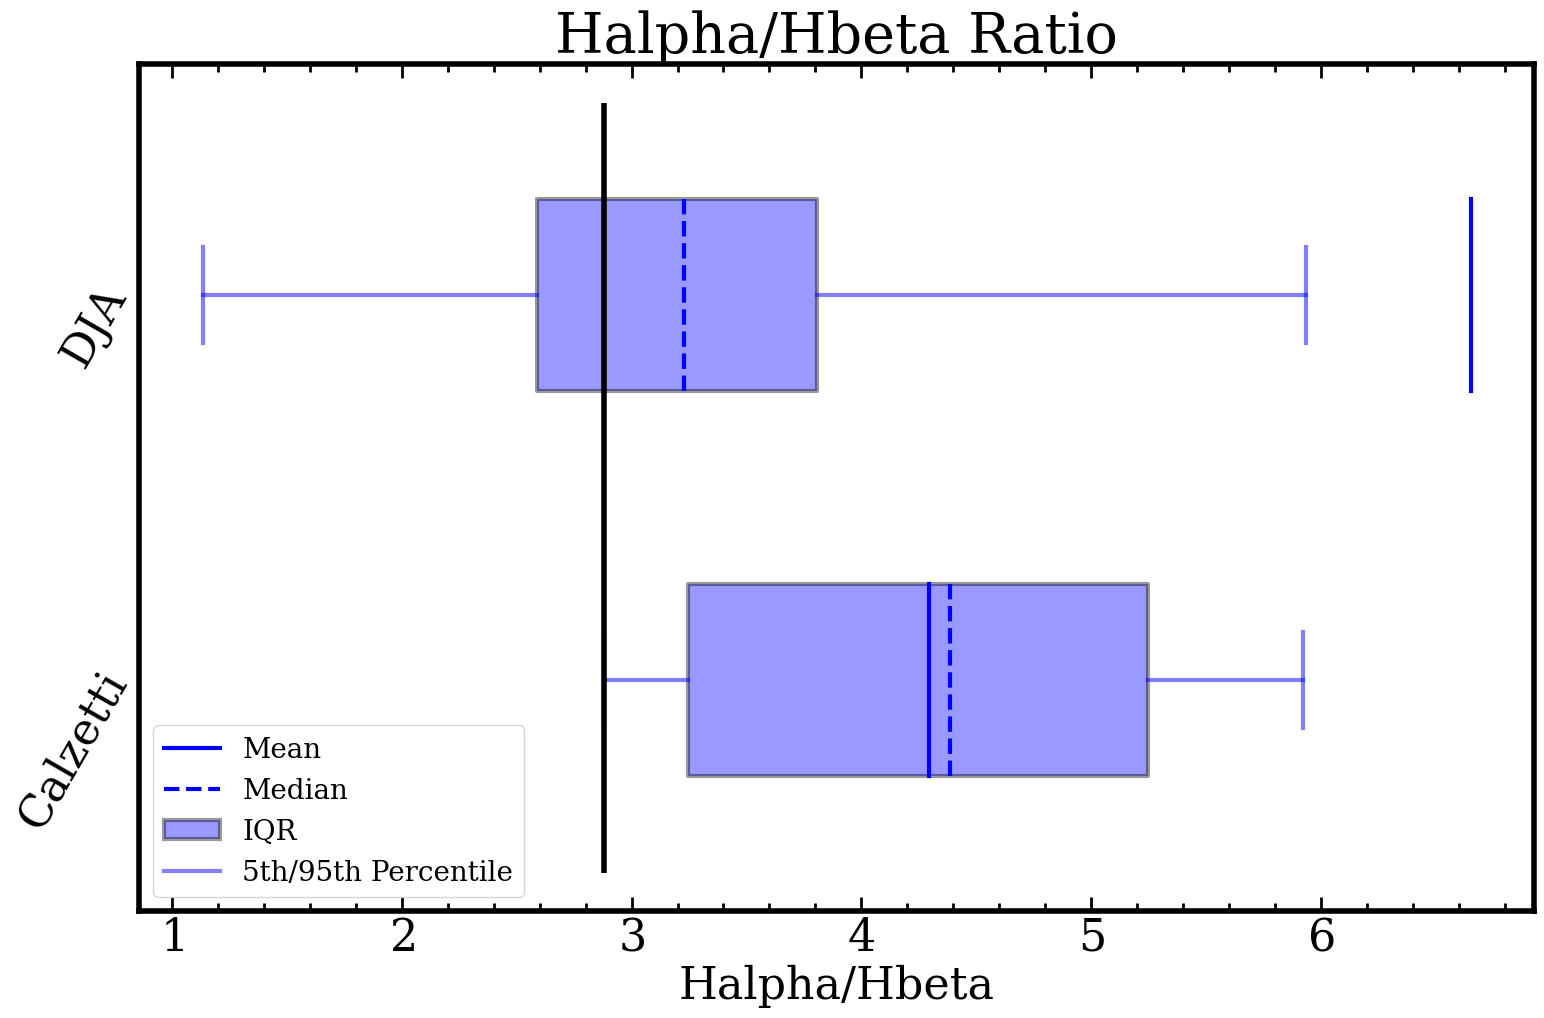

In [26]:
draw_bar_figure({'Number of Datasets':2,'0':Calzetti_ratio,'1':ratio,'Labels':['Calzetti','DJA']},'Halpha/Hbeta','Halpha/Hbeta Ratio')